<a href="https://colab.research.google.com/github/rsreds/Colabs/blob/master/ScanAnswer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load img2table library, to find tables in images using opencv
!pip install img2table

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://raw.githubusercontent.com/rsreds/Colabs/master/sample.jpg

--2023-02-17 12:04:44--  https://raw.githubusercontent.com/rsreds/Colabs/master/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745551 (728K) [image/jpeg]
Saving to: ‘sample.jpg.2’

sample.jpg.2        100%[===================>] 728.08K  --.-KB/s    in 0.05s   

2023-02-17 12:04:45 (15.8 MB/s) - ‘sample.jpg.2’ saved [745551/745551]



In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from img2table.document import Image

In [4]:
from emnist import extract_training_samples, extract_test_samples

In [5]:
X_train,y_train = extract_training_samples('balanced') # balanced dataset merges capital and lowercase letters only when the difference is minimal (C-c J-j O-o )
X_test,y_test = extract_test_samples('balanced')
classes = ['A', 'B', 'B', 'D'] # Classes 0-9 are for digits, 10 11 12 13
number_of_classes = len(classes)

In [6]:
filter_train = (y_train < (10 + number_of_classes)) & (y_train > 9)
filter_test = (y_test < (10 + number_of_classes)) & (y_test > 9)

In [7]:
y_train = y_train[filter_train]
X_train = X_train[filter_train]
y_test = y_test[filter_test]
X_test = X_test[filter_test]

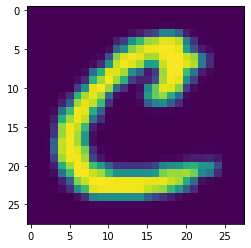

In [8]:
plt.imshow(X_train[1])

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

In [10]:
y_train = tf.keras.utils.to_categorical(y_train-10, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test-10, number_of_classes)

In [11]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

In [12]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [14]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=[MCP,ES,RLP])

Epoch 1/10
293/300 [============================>.] - ETA: 0s - loss: 7.9612 - accuracy: 0.8856
Epoch 1: val_accuracy improved from -inf to 0.88313, saving model to Best_points.h5
300/300 [==============================] - 9s 9ms/step - loss: 7.7819 - accuracy: 0.8873 - val_loss: 0.9330 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 2/10
299/300 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.9581
Epoch 2: val_accuracy improved from 0.88313 to 0.95688, saving model to Best_points.h5
300/300 [==============================] - 4s 12ms/step - loss: 0.3061 - accuracy: 0.9582 - val_loss: 0.3494 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 3/10
297/300 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9759
Epoch 3: val_accuracy improved from 0.95688 to 0.97000, saving model to Best_points.h5
300/300 [==============================] - 2s 7ms/step - loss: 0.1859 - accuracy: 0.9759 - val_loss: 0.3153 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 4/10
297/300 [=

In [15]:
filename = "/content/sample.jpg"
rows=3
columns=10

In [16]:
doc = Image(filename)
extracted_tables = doc.extract_tables(implicit_rows=False)

In [17]:
from img2table.tables.objects.extraction import BBox
img = cv2.imread(filename)
table_bbox = extracted_tables[0].bbox
table_height = table_bbox.y2-table_bbox.y1
table_width = table_bbox.x2-table_bbox.x1
cell_height = table_height / rows
cell_width = table_width / columns
cells_bb=[]
for r in range(rows):
    for c in range(columns):
        x1 = int(table_bbox.x1 + (cell_width * c))
        x2 = int(table_bbox.x1 + (cell_width * (c+1)))
        y1 = int(table_bbox.y1 + (cell_height * r))
        y2 = int(table_bbox.y1 + (cell_height * (r+1)))
        bbox=BBox(x1, y1, x2, y2)
        cells_bb.append(bbox)

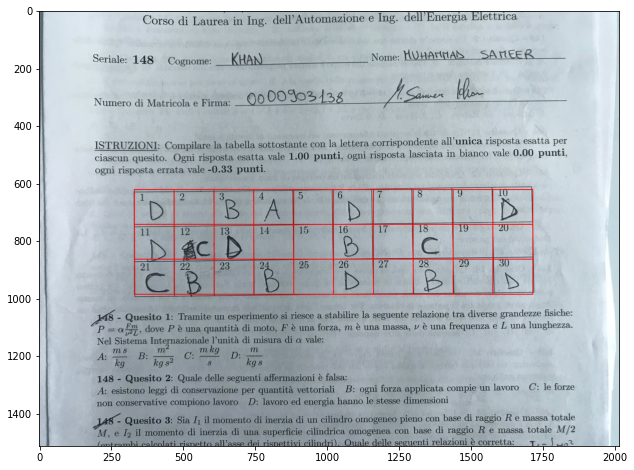

In [18]:
# Display extracted tables
img = cv2.imread(filename)
for cell in cells_bb:
    cv2.rectangle(img, (cell.x1, cell.y1), (cell.x2, cell.y2), (255, 0, 0), 2)
plt.figure(figsize=(20,8))            
plt.imshow(img);

In [19]:
!pip install emnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import imutils

def hide_number(image):
    width = 60
    height = 30
    blank_image = np.zeros((height, width), np.uint8)
    blank_image[:,:] = (image.min())
    image[0:height,0:width] = blank_image.copy()
    return image

def threshold(image):
    img = image.astype(np.uint8)
    # img = cv2.GaussianBlur(img,(3,3),0) # Helps in some cases
    _,result = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
    return result

def trim(image):
    contours,hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)

    trim_img = image[y:y+h,x:x+w]
    return trim_img
    
def resize_and_fill(image, width, height):
    pad_img = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    (original_height, original_width) = pad_img.shape[:2]

    blnk_image = np.zeros((width,height), np.uint8)
    blnk_image[:,:] = (0)

    if original_width > original_height:
        ratio = width / float(original_width)
        dim = (width, int(original_height*ratio))
    else:
        ratio = height / float(original_height)
        dim = (int(original_width*ratio), height)
    image = cv2.resize(pad_img, dim,  cv2.INTER_CUBIC)

    x_offset = (width-image.shape[1])//2
    y_offset = (height-image.shape[0])//2
    blnk_image[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image.copy()
    return blnk_image


In [21]:
def preprocess(image):
    image = cv2.normalize(image, None, 0, 255.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    th_img = threshold(image)
    clean_img = hide_number(th_img)
    trm_img = trim(clean_img)
    if trm_img is None:
        return None
    image = resize_and_fill(trm_img, 28, 28)
    return image

In [22]:
img = cv2.bitwise_not(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))
cell_images = [img[cell.y1+8:cell.y2-8,cell.x1+8:cell.x2-8] for cell in cells_bb]

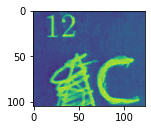

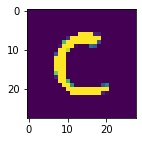

In [23]:
plt.figure(figsize=(2,2))
plt.imshow(cell_images[11])
plt.figure(figsize=(2,2))
plt.imshow(preprocess(cell_images[11]))

In [24]:
keys = ["index", "original", "filtered", "predict", "best", "class"]
answers = []
index = 0
for cell in cell_images:
    new_item = dict.fromkeys(keys)
    index += 1
    new_item["index"] = index
    new_item["original"] = cell
    filtered = preprocess(cell)
    new_item["filtered"] = filtered
    new_item["predict"] = None
    new_item["best"] = None
    new_item["class"] = None
    if filtered is None:
        answers.append(new_item)
        continue
    new_item["predict"] = model.predict(np.expand_dims(filtered, axis=0))
    new_item["best"] = new_item["predict"].max()
    new_item["class"] = new_item["predict"].argmax()
    answers.append(new_item)
    

1/1 [==============================] - 0s 18ms/step


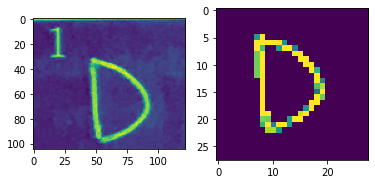

Question 1: predicted D  - 100.00%


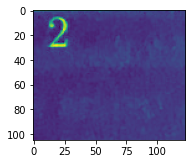

Question 2: answer not found


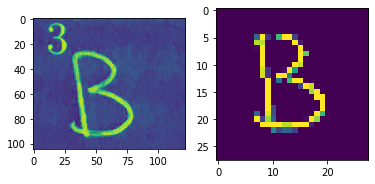

Question 3: predicted B  - 100.00%


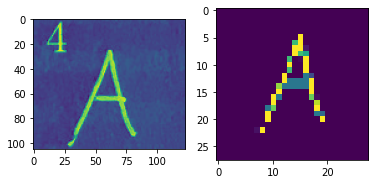

Question 4: predicted A  - 100.00%


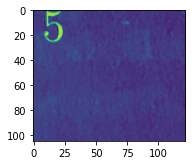

Question 5: answer not found


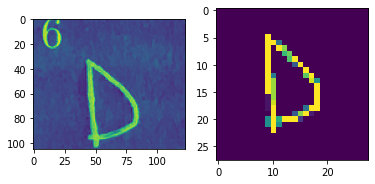

Question 6: predicted D  - 100.00%


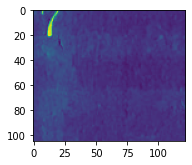

Question 7: answer not found


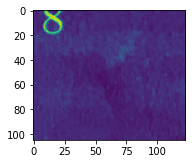

Question 8: answer not found


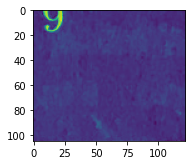

Question 9: answer not found


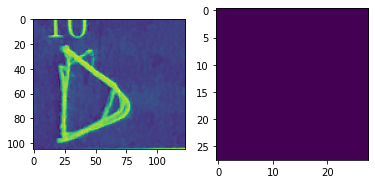

Question 10: predicted B  - 69.00%


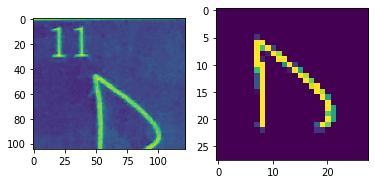

Question 11: predicted D  - 57.91%


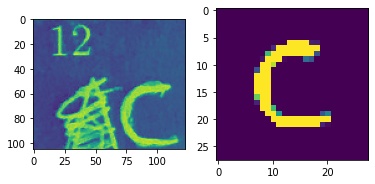

Question 12: predicted B  - 100.00%


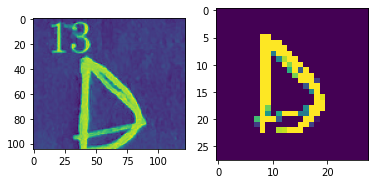

Question 13: predicted D  - 99.89%


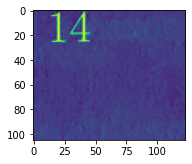

Question 14: answer not found


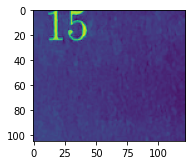

Question 15: answer not found


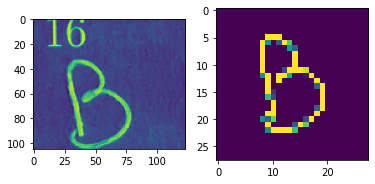

Question 16: predicted D  - 98.74%


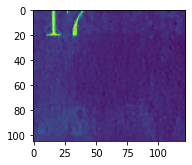

Question 17: answer not found


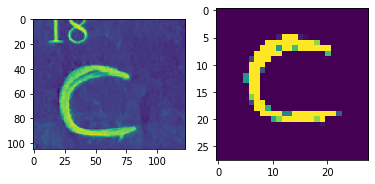

Question 18: predicted D  - 99.98%


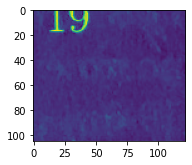

Question 19: answer not found


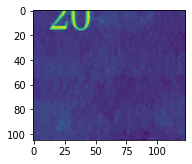

Question 20: answer not found


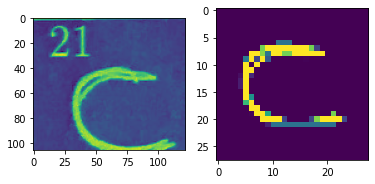

Question 21: predicted B  - 100.00%


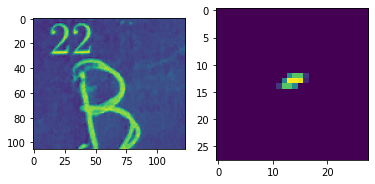

Question 22: predicted A  - 91.61%


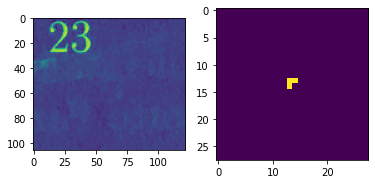

Question 23: predicted A  - 88.16%


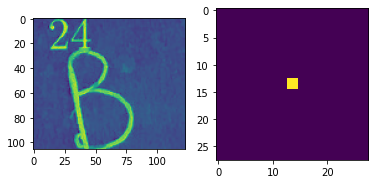

Question 24: predicted A  - 59.72%


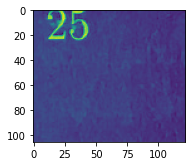

Question 25: answer not found


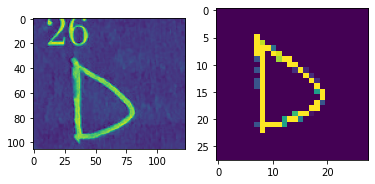

Question 26: predicted D  - 100.00%


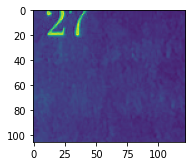

Question 27: answer not found


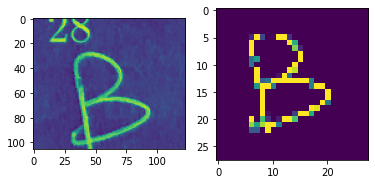

Question 28: predicted B  - 100.00%


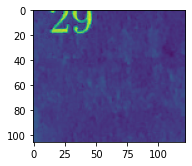

Question 29: answer not found


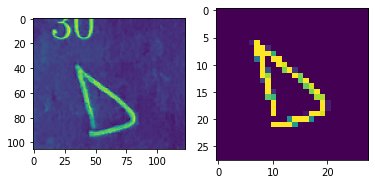

Question 30: predicted B  - 88.87%


In [25]:
for ans in answers:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(ans['original'])
    if ans['predict'] is None:
        plt.show()
        print(f"Question {ans['index']}: answer not found")
        continue
    plt.subplot(1,2,2)
    plt.imshow(ans['filtered'])
    plt.show()
    print(f"Question {ans['index']}: predicted {classes[ans['class']]}  - {ans['best']*100:.2f}%")